In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [2]:
cols = ['ts_event', 'symbol'] + \
       [f'bid_px_{i:02d}' for i in range(10)] + [f'ask_px_{i:02d}' for i in range(10)] + \
       [f'bid_sz_{i:02d}' for i in range(10)] + [f'ask_sz_{i:02d}' for i in range(10)]
df = pd.read_csv('first_25000_rows.csv', usecols=cols, parse_dates=['ts_event'])
df.sort_values(['symbol','ts_event'], inplace=True)

In [3]:
best_ofi = []
mlofi = []
depth = []

for sym, group in df.groupby('symbol'):
    prev = None
    for _, row in group.iterrows():
        if prev is None:
            best_ofi.append(0.0)
            mlofi.append([0.0]*10)
            depth.append(np.nan)
        else:
            # compute Q: average depth across 10 levels at prev
            s = sum(prev[f'bid_sz_{lvl:02d}'] + prev[f'ask_sz_{lvl:02d}'] for lvl in range(10))
            Q = s / (2*10)
            depth.append(Q)
            
            # Best-level OFI
            bid_px_old, bid_px_new = prev['bid_px_00'], row['bid_px_00']
            bid_sz_old, bid_sz_new = prev['bid_sz_00'], row['bid_sz_00']
            ask_px_old, ask_px_new = prev['ask_px_00'], row['ask_px_00']
            ask_sz_old, ask_sz_new = prev['ask_sz_00'], row['ask_sz_00']
            e_bid = 0.0
            if bid_px_old == 0 and bid_px_new > 0:
                e_bid = +bid_sz_new
            elif bid_px_old > 0 and bid_px_new == 0:
                e_bid = -bid_sz_old
            elif bid_px_old > 0 and bid_px_new > 0:
                e_bid = bid_sz_new if bid_px_new >= bid_px_old else -bid_sz_old
            e_ask = 0.0
            if ask_px_old > 0 and ask_px_new == 0:
                e_ask = +ask_sz_old
            elif ask_px_old == 0 and ask_px_new > 0:
                e_ask = -ask_sz_new
            elif ask_px_old > 0 and ask_px_new > 0:
                e_ask = -ask_sz_new if ask_px_new <= ask_px_old else +ask_sz_old
            best_ofi.append(e_bid + e_ask)
            
            # Multi-level OFI
            row_mlofi = []
            for lvl in range(10):
                px_b_old, px_b_new = prev[f'bid_px_{lvl:02d}'], row[f'bid_px_{lvl:02d}']
                sz_b_old, sz_b_new = prev[f'bid_sz_{lvl:02d}'], row[f'bid_sz_{lvl:02d}']
                px_a_old, px_a_new = prev[f'ask_px_{lvl:02d}'], row[f'ask_px_{lvl:02d}']
                sz_a_old, sz_a_new = prev[f'ask_sz_{lvl:02d}'], row[f'ask_sz_{lvl:02d}']
                e_b = 0.0
                if px_b_old==0 and px_b_new>0: e_b=+sz_b_new
                elif px_b_old>0 and px_b_new==0: e_b=-sz_b_old
                elif px_b_old>0 and px_b_new>0:
                    e_b = sz_b_new if px_b_new>=px_b_old else -sz_b_old
                e_a = 0.0
                if px_a_old>0 and px_a_new==0: e_a=+sz_a_old
                elif px_a_old==0 and px_a_new>0: e_a=-sz_a_new
                elif px_a_old>0 and px_a_new>0:
                    e_a = -sz_a_new if px_a_new<=px_a_old else +sz_a_old
                row_mlofi.append(e_b + e_a)
            mlofi.append(row_mlofi)
        prev = row

In [8]:
# Build df_ofi
records = []
i = 0
for sym, group in df.groupby('symbol'):
    for _ in group.itertuples():
        records.append((group.iat[ i%len(group), 0 ], sym))
        i += 1
df_ofi = pd.DataFrame({
    'ts_event': [r[0] for r in records],
    'symbol':   [r[1] for r in records],
    'best_ofi': best_ofi,
    'Q':        depth
})
for lvl in range(10):
    df_ofi[f'mlofi_{lvl}'] = [row[lvl] for row in mlofi]

# Normalize multilvl_ofi by Q
for lvl in range(10):
    df_ofi[f'mlofi_norm_{lvl}'] = df_ofi[f'mlofi_{lvl}'] / df_ofi['Q']

# Perform PCA on normalized OFI to compute integrated_ofi
df_ofi['integrated_ofi'] = 0.0
for sym, group in df_ofi.groupby('symbol'):
    cols = [f'mlofi_norm_{lvl}' for lvl in range(10)]
    X = group[cols].fillna(0).values
    pca = PCA(n_components=1)
    pca.fit(X)
    var_pct = pca.explained_variance_ratio_[0]*100
    print(f"{sym}: 1st PC explains {var_pct:.2f}% variance (with normalisation)")
    w = pca.components_[0]
    w /= np.sum(np.abs(w))
    df_ofi.loc[group.index, 'integrated_ofi'] = X.dot(w)


AAPL: 1st PC explains 23.08% variance (with normalisation)


In [14]:
df_ofi

,ts_event,symbol,best_ofi,Q,mlofi_0,mlofi_1,mlofi_2,mlofi_3,mlofi_4,mlofi_5,...,mlofi_norm_1,mlofi_norm_2,mlofi_norm_3,mlofi_norm_4,mlofi_norm_5,mlofi_norm_6,mlofi_norm_7,mlofi_norm_8,mlofi_norm_9,integrated_ofi
0,2024-10-21 11:54:29.221064336+00:00,AAPL,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,2024-10-21 11:54:29.223769812+00:00,AAPL,-59.0,99.45,-59.0,9.0,192.0,-122.0,-14.0,85.0,...,0.090498,1.930618,-1.226747,-0.140774,0.854701,-1.910508,0.663650,-0.553042,-3.469080,0.316612
2,2024-10-21 11:54:29.225030400+00:00,AAPL,-56.0,99.55,-56.0,9.0,192.0,-122.0,-14.0,85.0,...,0.090407,1.928679,-1.225515,-0.140633,0.853842,-1.908589,0.662983,-0.552486,-3.465595,0.315242
3,2024-10-21 11:54:29.712434212+00:00,AAPL,-56.0,99.70,-56.0,9.0,392.0,-122.0,-14.0,85.0,...,0.090271,3.931795,-1.223671,-0.140421,0.852558,-1.905717,0.661986,-0.551655,-3.460381,0.057883
4,2024-10-21 11:54:29.764673165+00:00,AAPL,-56.0,109.70,-56.0,9.0,192.0,-122.0,-14.0,85.0,...,0.082042,1.750228,-1.112124,-0.127621,0.774840,-1.731996,0.601641,-0.501367,-3.144941,0.286074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-10-21 13:04:16.583527688+00:00,AAPL,-19.0,108.10,-19.0,-100.0,73.0,-85.0,-291.0,9.0,...,-0.925069,0.675301,-0.786309,-2.691952,0.083256,-0.508788,-3.607771,-0.046253,-0.074006,0.897263
4996,2024-10-21 13:04:17.976461017+00:00,AAPL,-19.0,118.05,-19.0,-300.0,73.0,-85.0,-291.0,9.0,...,-2.541296,0.618382,-0.720034,-2.465057,0.076239,-0.465904,-3.303685,-0.042355,-0.067768,0.934465
4997,2024-10-21 13:04:20.085638629+00:00,AAPL,-19.0,128.05,-19.0,-300.0,-327.0,-115.0,-509.0,-11.0,...,-2.342835,-2.553690,-0.898087,-3.975010,-0.085904,-1.132370,-4.763764,-1.600937,-0.921515,2.032656
4998,2024-10-21 13:04:20.085651109+00:00,AAPL,-19.0,118.10,-19.0,-300.0,-112.0,100.0,-291.0,9.0,...,-2.540220,-0.948349,0.846740,-2.464014,0.076207,-0.465707,-3.302286,-0.042337,-0.067739,0.905789


In [9]:
for sym, group in df_ofi.groupby('symbol'):
    X = group[[f'mlofi_{i}' for i in range(10)]].values
    pca = PCA(n_components=2)
    pc1 = pca.fit_transform(X).flatten()
    var_pct = pca.explained_variance_ratio_[0]*100
    print(f"{sym}: 1st PC explains {var_pct:.2f}% variance (without normalisation)")

AAPL: 1st PC explains 23.02% variance (without normalisation)


In [15]:
#Cross-Asset OFI
if df_ofi['symbol'].nunique()>1:
    total = df_ofi.groupby('ts_event')['integrated_ofi'].transform('sum')
    df_ofi['cross_asset_ofi'] = total - df_ofi['integrated_ofi']
else:
    df_ofi['cross_asset_ofi'] = 0.0

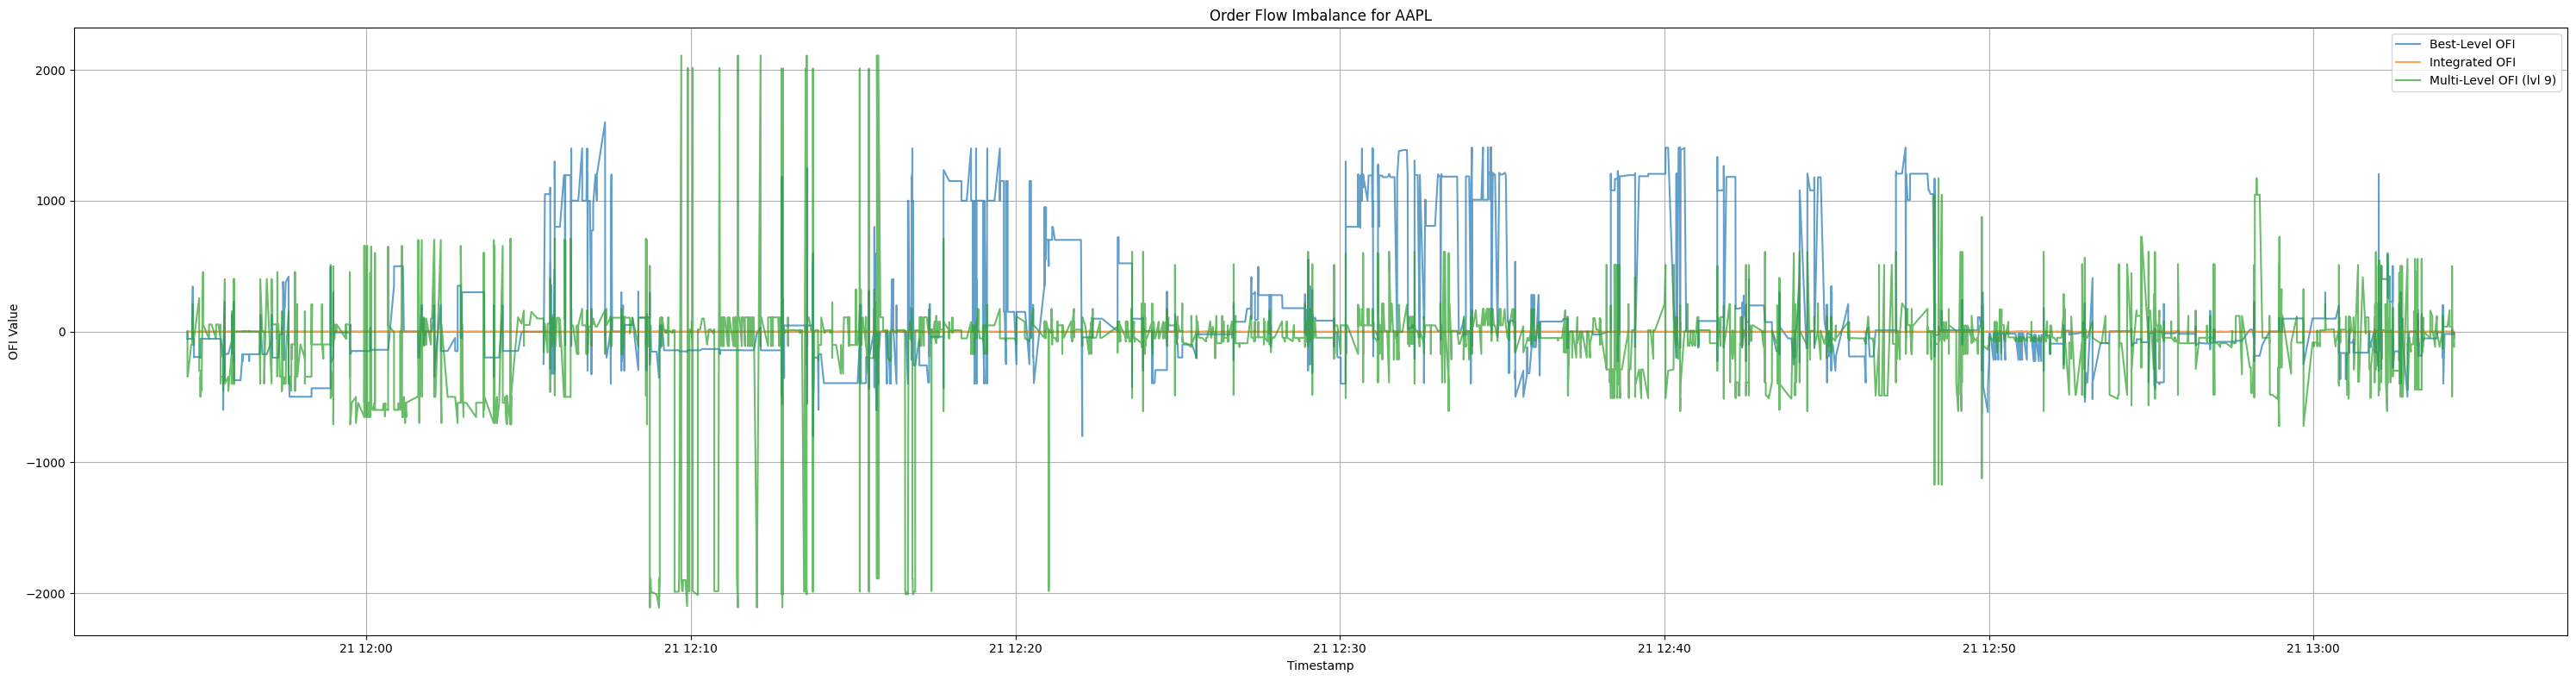

In [19]:
import matplotlib.pyplot as plt

symbol = 'AAPL'
df_plot = df_ofi[df_ofi['symbol'] == symbol].copy()

plt.figure(figsize=(30, 8))
plt.plot(df_plot['ts_event'], df_plot['best_ofi'], label='Best-Level OFI', alpha=0.7)
plt.plot(df_plot['ts_event'], df_plot['integrated_ofi'], label='Integrated OFI', alpha=0.7)
plt.plot(df_plot['ts_event'], df_plot['mlofi_9'], label='Multi-Level OFI (lvl 9)', alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('OFI Value')
plt.title(f'Order Flow Imbalance for {symbol}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

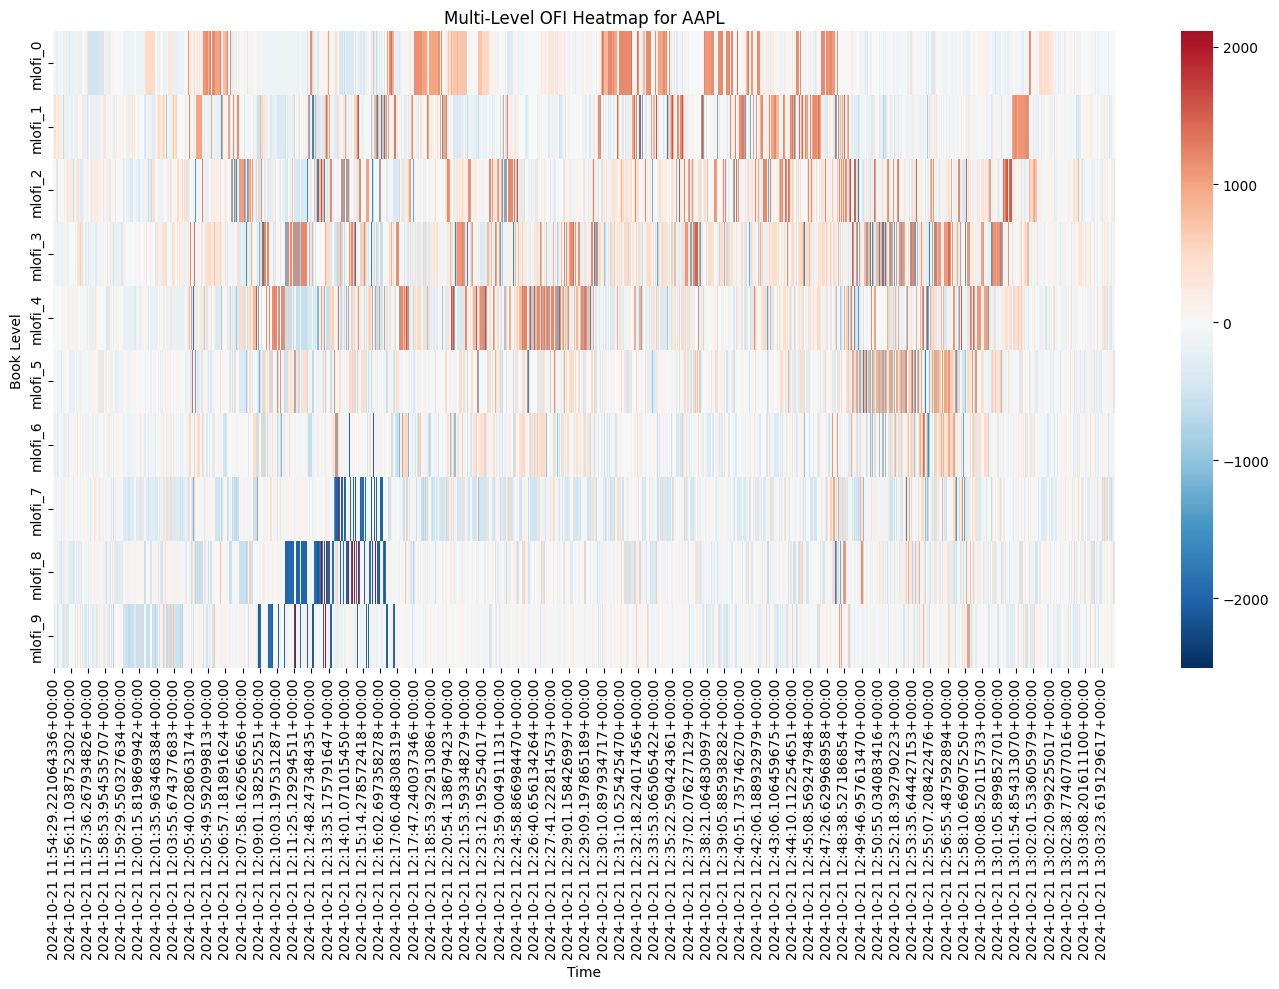

In [18]:
import seaborn as sns

# Create a matrix: rows = time, cols = level, values = OFI
ofi_matrix = df_plot[[f'mlofi_{i}' for i in range(10)]].T
ofi_matrix.columns = df_plot['ts_event'].astype(str)

plt.figure(figsize=(14, 10))
sns.heatmap(ofi_matrix, cmap='RdBu_r', center=0)
plt.title(f'Multi-Level OFI Heatmap for {symbol}')
plt.xlabel('Time')
plt.ylabel('Book Level')
plt.tight_layout()
plt.show()

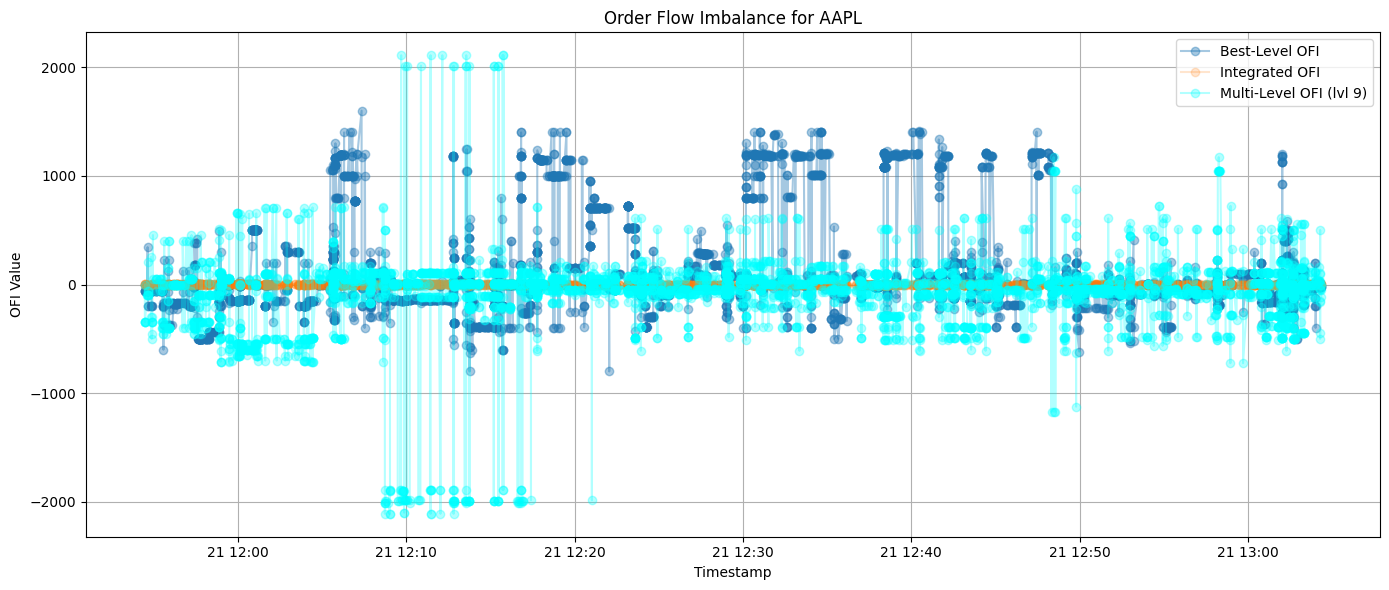

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(df_plot['ts_event'], df_plot['best_ofi'], marker = 'o', label='Best-Level OFI', alpha=0.4)
plt.plot(df_plot['ts_event'], df_plot['integrated_ofi'], marker = 'o', label='Integrated OFI', alpha=0.2)
plt.plot(df_plot['ts_event'], df_plot['mlofi_9'], marker = 'o', label='Multi-Level OFI (lvl 9)', alpha=0.3, color="cyan")

plt.xlabel('Timestamp')
plt.ylabel('OFI Value')
plt.title(f'Order Flow Imbalance for {symbol}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting Cross Asset Relationships
if df_ofi['symbol'].nunique() > 1:
    symbols = df_ofi['symbol'].unique()
    plt.figure(figsize=(14, 6))
    for sym in symbols:
        df_tmp = df_ofi[df_ofi['symbol'] == sym]
        plt.plot(df_tmp['ts_event'], df_tmp['cross_asset_ofi'], label=f'{sym} - Cross OFI')
    plt.title('Cross-Asset OFI Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Cross-Asset OFI')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# No symbol except AAPL in the data hence no plot